In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_small.txt', sep = "\t", names =  ['0', '1', '2', '3', '4', '5', '6'])

In [3]:
pd.DataFrame(df)

,0,1,2,3,4,5,6
0,0,40,50,0,0,1236,0
1,1,42,66,20,65,146,90
2,2,42,65,20,15,67,90
3,3,40,69,20,621,702,90
4,4,38,68,20,255,324,90
5,5,38,70,10,534,605,90
6,6,41,51,30,448,505,90


In [4]:
import numpy as np
from gurobipy import *

In [5]:

# read data_large.text and data_small.text

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read data_large.text and data_small.text
data_large = pd.read_csv('data_large.txt', sep='\t', names=['Location ID', 'X_Coordinate', 'Y_Coordinate', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])
data_small = pd.read_csv('data_small.txt', sep='\t', names=['Location ID', 'X_Coordinate', 'Y_Coordinate', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])

# show the entire data
#print(data_large)
print(data_small)


# first collum is location_ID
LOC_ID = (data_small.iloc[:,0])

# second collum is X_coordinate
X_COORD = (data_small.iloc[:,1])

# third collum is Y_coordinate
Y_COORD = (data_small.iloc[:,2])

# fourth collum is demand at the location
DEMAND = (data_small.iloc[:,3])

# fifth collum is ready time at the location
READYTIME = (data_small.iloc[:,4])

# sixth collum is due time at the location
DUETIME = (data_small.iloc[:,5])

# seventh collum is service time at the location
SERVICETIME = (data_small.iloc[:,6])

M = 1000000     # Large integer for 

c_matrix = np.zeros([len(LOC_ID), len(LOC_ID)])
for i in range(len(LOC_ID)):
    for j in range(len(LOC_ID)):
                if i == j:
                    c_matrix[i][j] = M
                else:
                    c_matrix[i][j] = np.sqrt((X_COORD[j] - X_COORD[i]) ** 2 + (Y_COORD[j] - Y_COORD[i]) ** 2)

print(c_matrix)

C:\Users\Daan\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


   Location ID  X_Coordinate  Y_Coordinate  Demand  Ready Time  Due Date  \
0            0            40            50       0           0      1236   
1            1            42            66      20          65       146   
2            2            42            65      20          15        67   
3            3            40            69      20         621       702   
4            4            38            68      20         255       324   
5            5            38            70      10         534       605   
6            6            41            51      30         448       505   

   Service Time  
0             0  
1            90  
2            90  
3            90  
4            90  
5            90  
6            90  
[[1.00000000e+06 1.61245155e+01 1.51327460e+01 1.90000000e+01
  1.81107703e+01 2.00997512e+01 1.41421356e+00]
 [1.61245155e+01 1.00000000e+06 1.00000000e+00 3.60555128e+00
  4.47213595e+00 5.65685425e+00 1.50332964e+01]
 [1.51327460e+01 1.00000000

In [6]:
model = Model ('Assignment_2b')

# ---- Sets ----

I = range (len(LOC_ID))                # set of Nodes
J = range (len(LOC_ID))                   # set of edges


# ---- Variables ----

# Decision Variable x(i,j) (Distance travelled between node i and node j)

x = {} 
for j in J:
    x[j] = model.addVar(vtype = GRB.BINARY, name = 'x[' + str(j) + ']')

# Decision Variable x(i,j) (Distance travelled between node i and node j)

z = {} 
for j in J:
    z[j] = model.addVar(vtype = GRB.CONTINUOUS, name = 'z[' + str(j) + ']')
        
# Integrate new variables
model.update ()


# ---- Objective Function ----

model.setObjective(quicksum((c[j] * x[j]) for j in J))
model.modelSense = GRB.MINIMIZE
model.update ()


# ---- Constraints ----

# Contraint 1: distance between the nodes

model.addConstr( quicksum(x[i, j] for j in I if j! = i) == 1 for i in I)
model.addConstr( quicksum(x[i, j] for i in I if j! = i) == 1 for j in I)

model.addConstr( (x[i, j] == 1) >> (u[i] + 1 == u[j] ) for i, j in J if j! = 0)

# Contraint 2


# Contraint 3: stock in other months

# ---- Solve ----


model.setParam('OutputFlag', True) # silencing gurobi output or not
model.setParam ('MIPGap', 0);       # find the optimal solution
model.write("output.lp")            # print the model in .lp format file

model.optimize ()


SyntaxError: invalid syntax (<ipython-input-6-719909f4dd7e>, line 38)

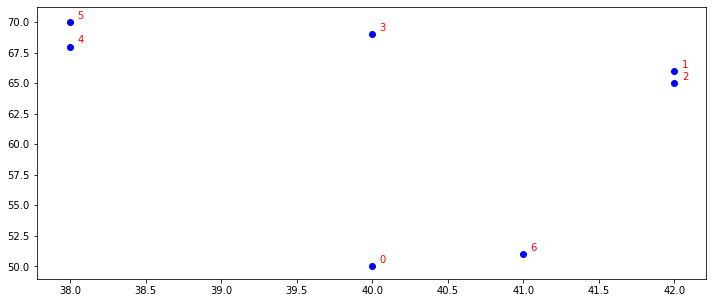

In [52]:
plt.figure(figsize = (12, 5))
for i in range(len(LOC_ID)):
    plt.scatter(X_COORD[i], Y_COORD[i], color = 'blue') 
    plt.annotate(str(LOC_ID[i]), xy = (X_COORD[i], Y_COORD[i]), xytext = (X_COORD[i] + 0.05, Y_COORD[i] + 0.3), color = 'red')